In [1]:
import matplotlib.pyplot as plt  # type: ignore
from dotenv import load_dotenv
import sqlalchemy as sq
import seaborn as sns  # type: ignore
import pandas as pd  # type: ignore
import numpy as np
import os, sys

sys.path.append("../")
from Shared.DataService import DataService

In [2]:
load_dotenv()
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")

In [3]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

In [4]:
mbQuery = sq.text("SELECT * FROM public.mb_hly_station_data")
mb_df = pd.read_sql(mbQuery, conn)

skQuery = sq.text("SELECT * FROM public.sk_hly_station_data")
sk_df = pd.read_sql(skQuery, conn)

abQuery = sq.text("SELECT * FROM public.ab_hly_station_data")
ab_df = pd.read_sql(abQuery, conn)

hlyDF = pd.concat([mb_df, sk_df, ab_df])

In [5]:
stationDataQuery = sq.text(
    """
    SELECT station_id, district FROM public.stations_hly
    WHERE district IS NOT NULL;
    """
)

stationData = pd.read_sql(stationDataQuery, conn)
stationData[["district"]] = stationData[["district"]].astype(int)

In [6]:
hlyDF = hlyDF.merge(stationData, on="station_id")

In [7]:
ergotQuery = sq.text(
    """
    SELECT year, district, percnt_true, has_ergot, sum_severity, present_prev1, present_prev2, present_prev3, present_in_neighbor, severity_prev1, 
        severity_prev2, severity_prev3, severity_in_neighbor FROM public.agg_ergot_samples
    GROUP BY year, district, percnt_true, has_ergot, sum_severity, present_prev1, present_prev2, present_prev3, present_in_neighbor, severity_prev1, 
        severity_prev2, severity_prev3, severity_in_neighbor;
    """
)

ergotDF = pd.read_sql_query(ergotQuery, conn)

In [8]:
db.cleanup()

In [9]:
final_df = hlyDF.merge(ergotDF, on=["year", "district"])

In [10]:
final_df.columns

Index(['id', 'station_id', 'year', 'month', 'day', 'min_temp', 'max_temp',
       'mean_temp', 'min_dew_point_temp', 'max_dew_point_temp',
       'mean_dew_point_temp', 'min_humidex', 'max_humidex', 'mean_humidex',
       'total_precip', 'min_rel_humid', 'max_rel_humid', 'mean_rel_humid',
       'min_stn_press', 'max_stn_press', 'mean_stn_press', 'min_visibility',
       'max_visibility', 'mean_visibility', 'district', 'percnt_true',
       'has_ergot', 'sum_severity', 'present_prev1', 'present_prev2',
       'present_prev3', 'present_in_neighbor', 'severity_prev1',
       'severity_prev2', 'severity_prev3', 'severity_in_neighbor'],
      dtype='object')

In [11]:
final_df.drop(columns=["id", "station_id", "year", "month", "day"], inplace=True)

In [12]:
# Compute the correlation matrix
corr = final_df.corr()

In [13]:
corr

,min_temp,max_temp,mean_temp,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,mean_humidex,total_precip,...,has_ergot,sum_severity,present_prev1,present_prev2,present_prev3,present_in_neighbor,severity_prev1,severity_prev2,severity_prev3,severity_in_neighbor
min_temp,1.000000,0.929302,0.975468,0.958966,0.929253,0.954306,0.057806,0.466541,0.421301,0.004778,...,0.026876,-0.002367,0.028459,0.026414,0.026791,0.001561,0.002539,-0.003511,0.013601,-0.006722
max_temp,0.929302,1.000000,0.983418,0.884178,0.916293,0.909172,0.045274,0.530458,0.470832,0.003266,...,0.045302,-0.007276,0.046023,0.045620,0.045183,0.001597,-0.000433,0.002015,0.013150,0.003092
mean_temp,0.975468,0.983418,1.000000,0.931655,0.937358,0.946186,0.051462,0.510964,0.459405,0.004096,...,0.036490,-0.005064,0.038005,0.036821,0.036885,0.001617,0.000210,-0.000114,0.013793,-0.001083
min_dew_point_temp,0.958966,0.884178,0.931655,1.000000,0.948412,0.984965,0.053425,0.457036,0.411354,0.004653,...,0.032025,0.002737,0.032603,0.029797,0.029707,0.006963,0.010802,-0.001072,0.018928,-0.009007
max_dew_point_temp,0.929253,0.916293,0.937358,0.948412,1.000000,0.983321,0.054737,0.506248,0.456640,0.005924,...,0.029575,0.002245,0.028144,0.025212,0.025874,0.006711,0.001067,-0.003062,0.013097,-0.012778
mean_dew_point_temp,0.954306,0.909172,0.946186,0.984965,0.983321,1.000000,0.055002,0.487549,0.439796,0.005591,...,0.031669,0.002562,0.031558,0.028528,0.028866,0.007236,0.006732,-0.001646,0.017072,-0.010507
min_humidex,0.057806,0.045274,0.051462,0.053425,0.054737,0.055002,1.000000,0.096487,0.220660,-0.000309,...,-0.018958,0.001878,-0.016152,-0.018031,-0.015585,-0.001044,-0.009090,-0.007570,-0.005687,-0.010753
max_humidex,0.466541,0.530458,0.510964,0.457036,0.506248,0.487549,0.096487,1.000000,0.892334,0.003092,...,0.001426,0.007486,0.003036,0.003931,0.008602,0.001557,-0.010832,-0.011457,0.002814,-0.004188
mean_humidex,0.421301,0.470832,0.459405,0.411354,0.456640,0.439796,0.220660,0.892334,1.000000,0.002085,...,-0.010597,0.007307,-0.004961,-0.004384,0.001787,-0.001117,-0.016562,-0.017496,0.000216,-0.018000
total_precip,0.004778,0.003266,0.004096,0.004653,0.005924,0.005591,-0.000309,0.003092,0.002085,1.000000,...,0.003208,-0.001109,0.003526,0.004097,0.004623,0.001271,0.002248,0.000069,-0.000900,-0.002813


<Axes: >

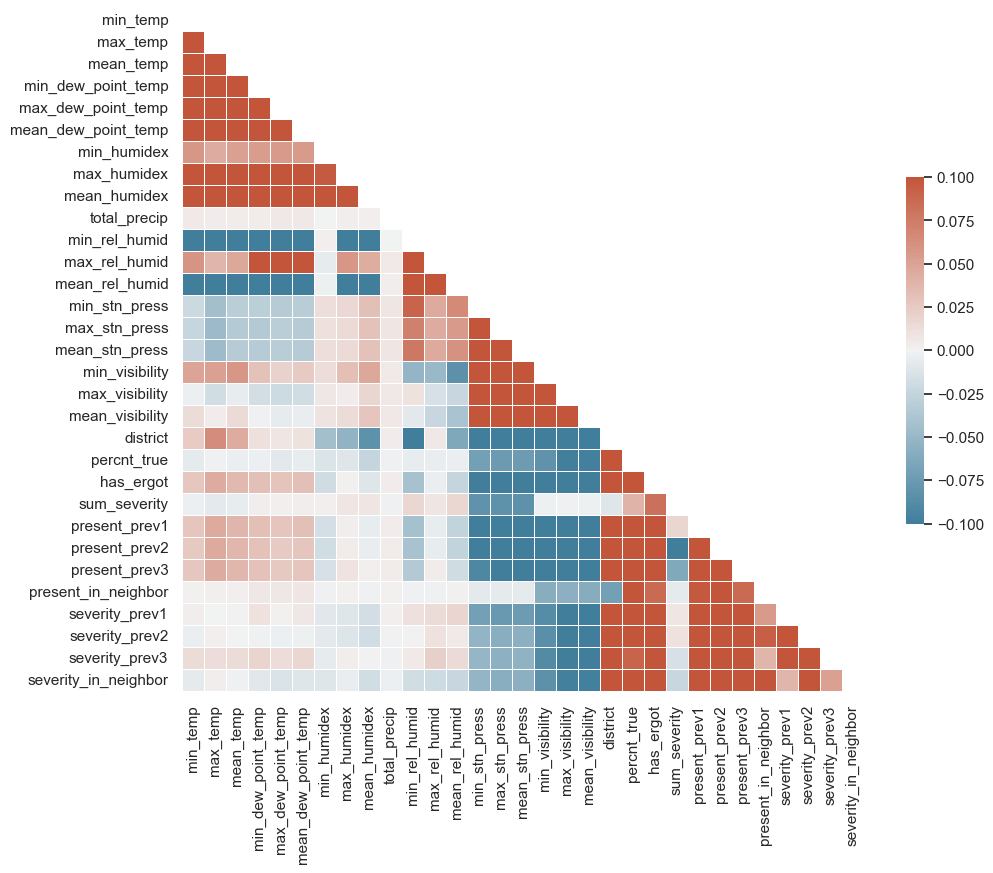

In [14]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.1,
    vmin=-0.1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

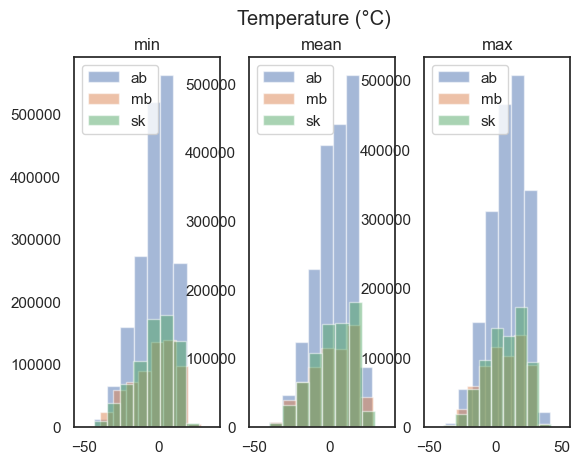

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Temperature (°C)")


ax1.hist(ab_df["min_temp"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_temp"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_temp"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_temp"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_temp"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_temp"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_temp"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_temp"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_temp"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

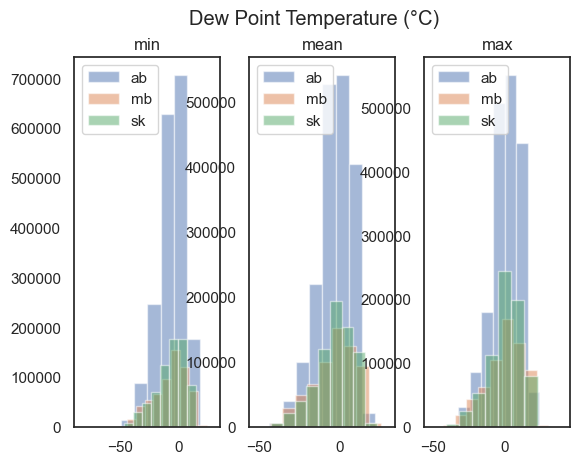

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Dew Point Temperature (°C)")


ax1.hist(ab_df["min_dew_point_temp"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_dew_point_temp"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_dew_point_temp"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_dew_point_temp"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_dew_point_temp"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_dew_point_temp"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_dew_point_temp"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_dew_point_temp"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_dew_point_temp"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

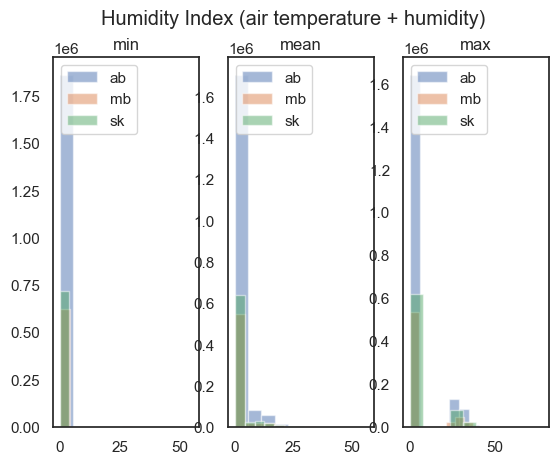

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Humidity Index (air temperature + humidity)")


ax1.hist(ab_df["min_humidex"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_humidex"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_humidex"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_humidex"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_humidex"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_humidex"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_humidex"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_humidex"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_humidex"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

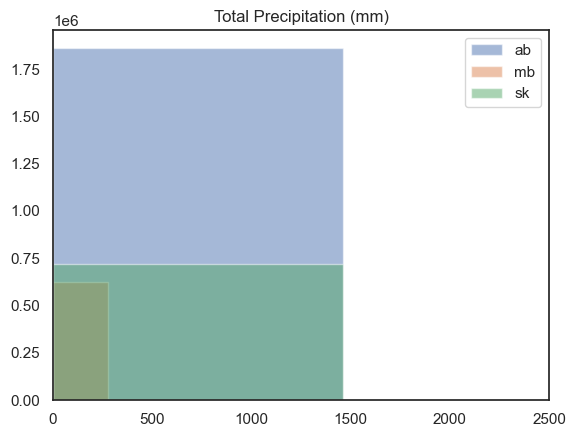

In [37]:
plt.hist(ab_df["total_precip"], alpha=0.5, label="ab")
plt.hist(mb_df["total_precip"], alpha=0.5, label="mb")
plt.hist(sk_df["total_precip"], alpha=0.5, label="sk")
plt.legend(loc="upper right")
plt.title("Total Precipitation (mm)")
plt.xlim(0, 2500)
plt.show()

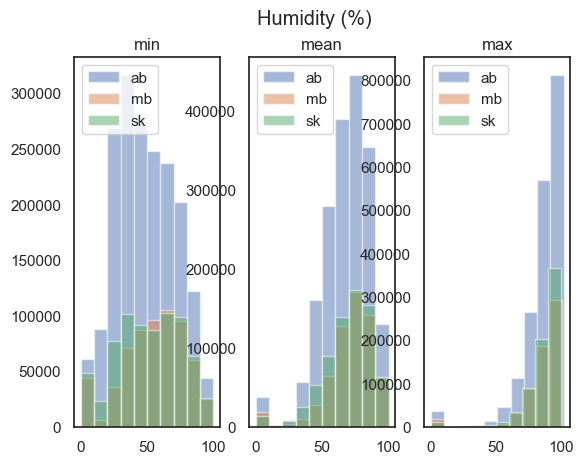

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Humidity (%)")


ax1.hist(ab_df["min_rel_humid"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_rel_humid"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_rel_humid"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_rel_humid"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_rel_humid"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_rel_humid"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_rel_humid"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_rel_humid"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_rel_humid"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

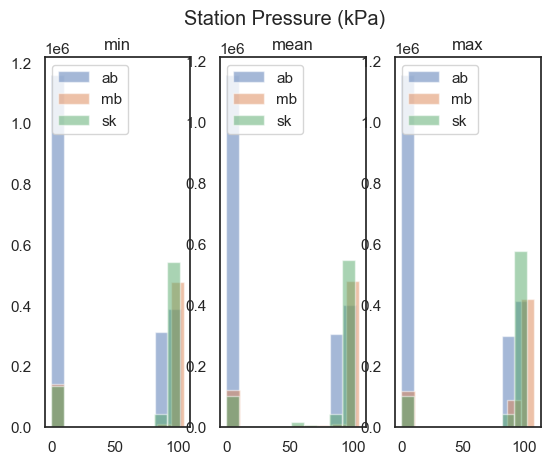

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Station Pressure (kPa)")


ax1.hist(ab_df["min_stn_press"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_stn_press"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_stn_press"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_stn_press"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_stn_press"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_stn_press"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_stn_press"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_stn_press"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_stn_press"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

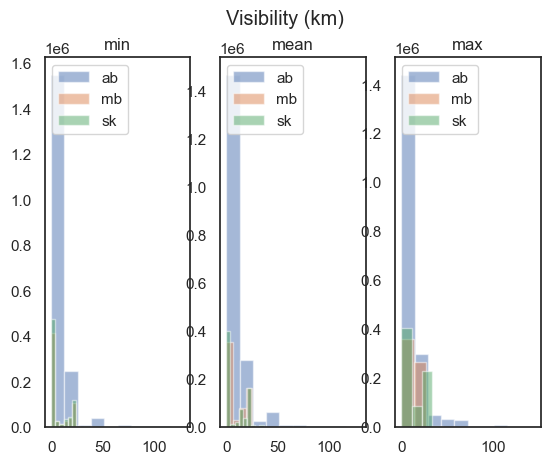

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Visibility (km)")


ax1.hist(ab_df["min_visibility"], alpha=0.5, label="ab")
ax1.hist(mb_df["min_visibility"], alpha=0.5, label="mb")
ax1.hist(sk_df["min_visibility"], alpha=0.5, label="sk")
ax1.title.set_text("min")
ax1.legend(loc="upper left")

ax2.hist(ab_df["mean_visibility"], alpha=0.5, label="ab")
ax2.hist(mb_df["mean_visibility"], alpha=0.5, label="mb")
ax2.hist(sk_df["mean_visibility"], alpha=0.5, label="sk")
ax2.title.set_text("mean")
ax2.legend(loc="upper left")

ax3.hist(ab_df["max_visibility"], alpha=0.5, label="ab")
ax3.hist(mb_df["max_visibility"], alpha=0.5, label="mb")
ax3.hist(sk_df["max_visibility"], alpha=0.5, label="sk")
ax3.title.set_text("max")
ax3.legend(loc="upper left")

In [22]:
mb_df.drop(columns=["id", "station_id", "year", "month", "day"], inplace=True)
sk_df.drop(columns=["id", "station_id", "year", "month", "day"], inplace=True)
ab_df.drop(columns=["id", "station_id", "year", "month", "day"], inplace=True)

In [23]:
mb_df.describe()

,min_temp,max_temp,mean_temp,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,mean_humidex,total_precip,min_rel_humid,max_rel_humid,mean_rel_humid,min_stn_press,max_stn_press,mean_stn_press,min_visibility,max_visibility,mean_visibility
count,619844.000000,619844.000000,619844.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000,624593.000000
mean,-3.598270,5.710687,1.258134,-6.714903,-0.109963,-3.297272,0.151030,4.334602,1.803944,0.302239,54.167370,85.300466,70.530695,75.809184,79.739005,78.191495,6.470617,9.665723,8.598951
std,14.382176,15.201620,14.571109,14.195419,12.745656,13.281672,2.037656,10.599707,5.238551,6.268521,23.624801,17.551587,18.755044,40.852471,38.669083,38.757410,9.509493,11.112928,10.267418
min,-47.800000,-47.800000,-47.800000,-51.900000,-51.100000,-51.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-14.100000,-5.600000,-9.500000,-16.200000,-7.700000,-11.804167,0.000000,0.000000,0.000000,0.000000,40.000000,81.000000,63.000000,94.600000,96.190000,94.972500,0.000000,0.000000,0.000000
50%,-1.300000,6.700000,2.766667,-3.900000,0.200000,-1.200000,0.000000,0.000000,0.000000,0.000000,57.000000,90.000000,73.583333,97.360000,98.150000,97.713889,0.000000,0.000000,0.000000
75%,8.300000,18.900000,13.854659,4.300000,10.100000,7.326087,0.000000,0.000000,0.000000,0.000000,72.000000,95.000000,82.833333,98.430000,99.140000,98.762083,15.000000,24.100000,19.900000
max,36.600000,40.200000,37.114286,24.400000,30.000000,26.104167,43.000000,53.000000,43.000000,2790.000000,100.000000,101.000000,100.000000,104.480000,107.960000,104.727500,40.200000,136.800000,63.580000


In [24]:
sk_df.describe()

,min_temp,max_temp,mean_temp,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,mean_humidex,total_precip,min_rel_humid,max_rel_humid,mean_rel_humid,min_stn_press,max_stn_press,mean_stn_press,min_visibility,max_visibility,mean_visibility
count,716117.000000,716117.000000,716117.000000,719155.000000,719155.00000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000,719155.000000
mean,-3.000081,7.530920,2.427138,-6.485028,0.40911,-2.917143,0.064764,4.044661,1.450593,1.283184,50.430913,85.907800,68.786666,77.001121,81.751667,79.695156,6.562997,9.846082,8.724209
std,13.174592,14.539196,13.612269,12.686286,11.11752,11.659071,1.342274,10.142087,4.283060,96.031298,24.514301,15.389935,18.493408,36.701849,33.146666,33.523188,9.725712,11.361639,10.434977
min,-52.300000,-48.700000,-48.700000,-54.800000,-49.80000,-49.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-11.500000,-2.900000,-6.950000,-13.700000,-5.60000,-9.443304,0.000000,0.000000,0.000000,0.000000,32.000000,82.000000,59.000000,91.540000,93.010000,91.897446,0.000000,0.000000,0.000000
50%,-1.100000,8.900000,3.929167,-4.400000,0.70000,-1.546154,0.000000,0.000000,0.000000,0.000000,52.000000,90.000000,71.833333,94.190000,95.010000,94.526250,0.000000,0.000000,0.000000
75%,7.800000,19.800000,14.004167,3.000000,9.20000,6.166667,0.000000,0.000000,0.000000,0.000000,70.000000,95.000000,82.041667,95.420000,96.180000,95.735833,15.000000,24.100000,19.300000
max,35.600000,41.900000,39.233333,23.300000,40.50000,23.441667,40.000000,78.000000,42.142857,14629.600000,100.000000,100.000000,100.000000,101.560000,102.200000,101.887500,40.200000,112.700000,40.200000


In [25]:
ab_df.describe()

,min_temp,max_temp,mean_temp,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,mean_humidex,total_precip,min_rel_humid,max_rel_humid,mean_rel_humid,min_stn_press,max_stn_press,mean_stn_press,min_visibility,max_visibility,mean_visibility
count,1.858674e+06,1.858674e+06,1.858674e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06,1.861069e+06
mean,-2.393472e+00,8.898326e+00,3.363827e+00,-6.001670e+00,4.790289e-01,-2.652889e+00,1.518751e-02,3.384209e+00,1.084989e+00,7.933402e-01,4.797870e+01,8.546863e+01,6.759043e+01,3.468198e+01,3.517982e+01,3.500442e+01,4.924634e+00,7.154421e+00,6.320719e+00
std,1.156204e+01,1.315859e+01,1.211311e+01,1.113542e+01,9.920030e+00,1.033794e+01,6.425649e-01,9.275830e+00,3.477666e+00,7.065903e+01,2.212427e+01,1.647147e+01,1.788886e+01,4.461425e+01,4.497360e+01,4.477696e+01,1.234352e+01,1.596624e+01,1.419030e+01
min,-5.250000e+01,-4.780000e+01,-4.860000e+01,-8.370000e+01,-4.830000e+01,-5.206667e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-9.400000e+00,2.000000e-01,-4.320833e+00,-1.230000e+01,-4.900000e+00,-8.450000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,8.100000e+01,5.754167e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-7.000000e-01,1.010000e+01,4.691667e+00,-4.700000e+00,5.000000e-01,-1.775000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,9.000000e+01,6.991667e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.800000e+00,1.960000e+01,1.331667e+01,2.300000e+00,8.200000e+00,5.362500e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.500000e+01,9.500000e+01,8.037500e+01,9.083000e+01,9.145000e+01,9.112792e+01,0.000000e+00,0.000000e+00,0.000000e+00
max,3.630000e+01,5.100000e+01,3.675000e+01,3.030000e+01,3.160000e+01,3.095000e+01,5.500000e+01,5.800000e+01,5.650000e+01,1.463120e+04,1.000000e+02,1.020000e+02,1.000000e+02,1.021800e+02,1.026000e+02,1.023900e+02,1.287000e+02,1.448000e+02,1.287000e+02
